# Prepare environment

In [1]:
import cv2
import torch
from matplotlib import pyplot as plt
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

from dataset.STARCOP_dataset import STARCOPDataset
from dataset.dataset_info import ClassifierDatasetInfo
from dataset.dataset_type import DatasetType
from models.Tools.FilesHandler.model_files_handler import ModelFilesHandler

import os
os.chdir(r"C:\Users\mpilc\Desktop\Studia\Thesis\Repozytoria\Thesis")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load sample images

In [3]:
dataset = STARCOPDataset(
    data_path=r"data",
    data_type=DatasetType.TEST,
    image_info_class=ClassifierDatasetInfo,
    normalization=False
)

dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

# Visualize inputs

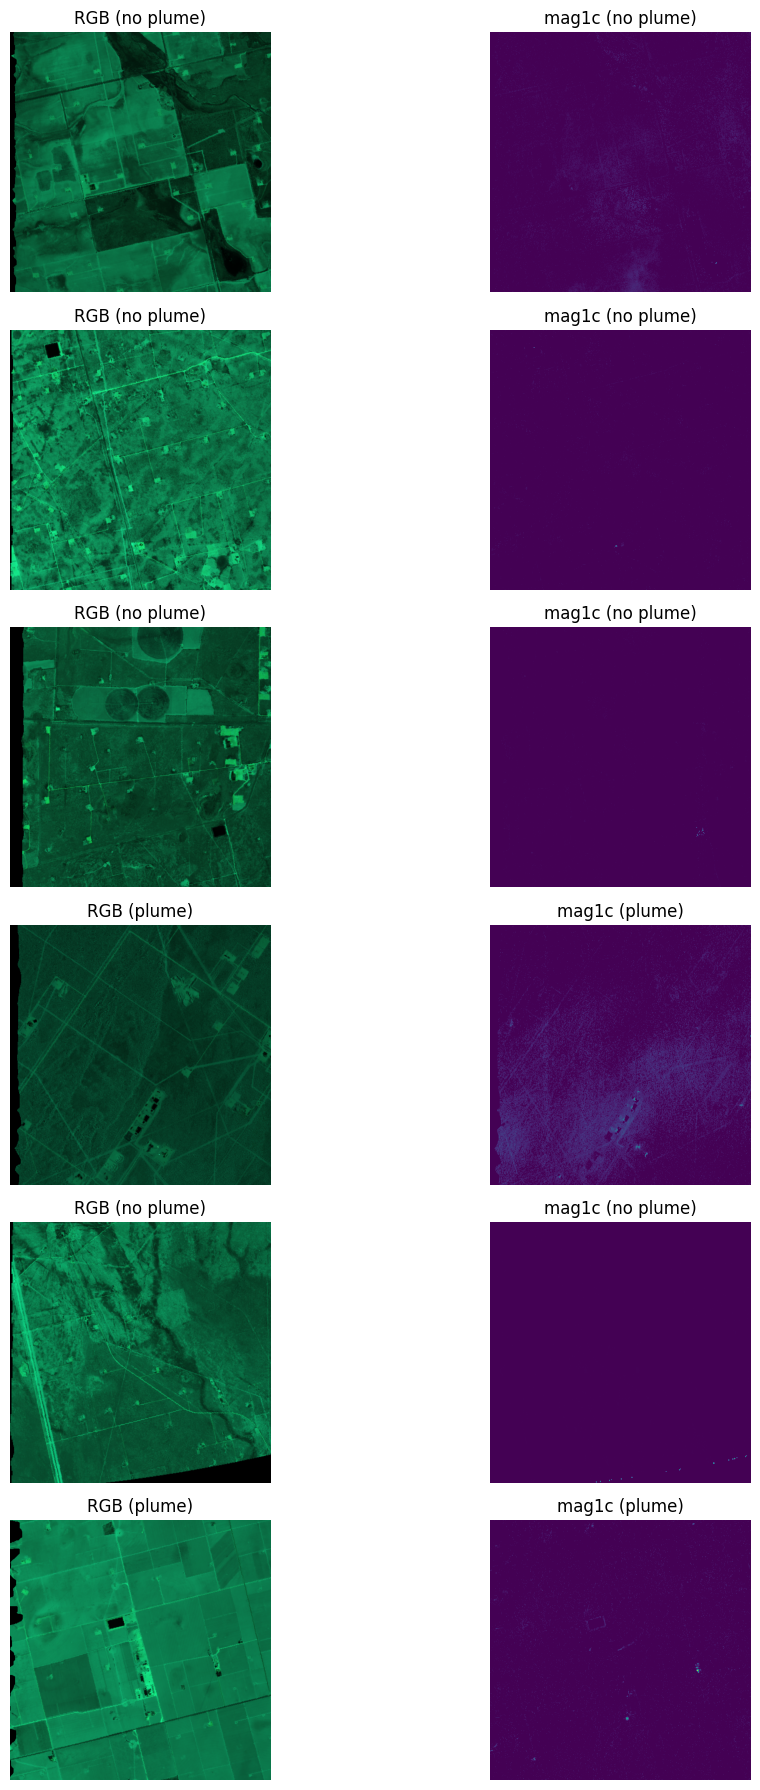

In [4]:
images = next(iter(dataloader))
transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.Normalize(mean=[0.5] * 9, std=[0.5] * 9)  # Normalize for 9 channels
    ])
# Create a figure with subplots
fig, ax = plt.subplots(6, 2, figsize=(12, 18))  # 6 row, 3 columns

# Display the first image
for i in range(images[0].shape[0]):
    image_rgb = images[0][i, :3, :, :].permute(1, 2, 0).numpy()
    image_mag1c = images[1][i].squeeze(0).numpy()
    
    image_rgb = image_rgb - image_rgb.min()  # Shift minimum to 0
    image_rgb = image_rgb / image_rgb.max()  # Scale maximum to 1
    
    plume = images[2][i].item()
    ax[i, 0].imshow(image_rgb)
    ax[i, 0].set_title(f"RGB ({"plume" if plume == True else "no plume"})")
    ax[i, 0].axis('off') 
    
    # Display the second image
    ax[i, 1].imshow(image_mag1c)  # Automatically handles RGB
    ax[i, 1].set_title(f"mag1c ({"plume" if plume == True else "no plume"})")
    ax[i, 1].axis('off')  # Turn off axis
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.tight_layout()
plt.show()

# Prepare input for model 

In [5]:
input_image = torch.cat((images[0], images[1]), dim=1)
input_image = transform(input_image).to(device)

# Prepare model

In [7]:
file_name = r"trained_models\model_transformer_classifier_2024_11_30_10_22_44.pickle"

model_handler = ModelFilesHandler()
model, model_type, metrics, epoch = model_handler.load_model(file_name=file_name)

model.eval()
model.to(device)

CustomViT(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(9, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNo

# Show performance

In [9]:
outputs = model(input_image.to(device))
print(f"Labels:  {images[2].numpy()}")
print(f"Outputs: {torch.argmax(outputs, dim=1).bool().to("cpu").numpy()}")

Labels:  [False False False  True False  True]
Outputs: [ True False False  True False False]


In [10]:
metrics

,TP,FP,FN,TN,Precision,Sensitivity,Specificity,NPV,FPR,Accuracy,F-Score,IoU,MCC,AUC,CI
0,0.255132,0.09824,0.183284,0.463343,0.72199,0.581938,0.825064,0.716552,0.174934,0.718474,0.644442,0.47541,0.422479,0.703503,0.025378
